In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np      
import datetime as dt
from scipy.signal import medfilt, detrend, coherence, windows
import os

In [2]:
# Input processed data location
d_loc = '/Volumes/Data/ICECAPSarchive/fluxtower/processed/LiCOR/'

# Start and stop date:
start = dt.datetime(2019,5,28,0,0)
stop = dt.datetime(2019,5,30,0,0)

# Days to loop through
days = pd.date_range(start,stop,freq='1D')

licor = pd.DataFrame(columns=['Ndx','DiagV','CO2R','CO2D','H2OR','H2OD','T','P','cooler'])

## Start loop ##
for day in days:
    day_str = str(day.date()) 
    print(day_str)
    if os.path.isfile(d_loc+'licor_%s'%day_str):
        licor = licor.append(pd.read_csv(d_loc+'licor_%s'%day_str, index_col=0, parse_dates=[0]))




2019-05-28
2019-05-29
2019-05-30


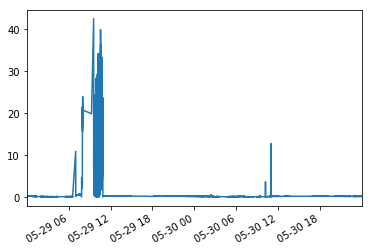

In [4]:
# Clean pressure for values over 80000 or under 50000
# Clean temperature for values under 200 or over 300
# Clean H20D for values over 10000 or less than zero 
licor = licor[licor['H2OD']>0]
licor = licor[licor['H2OD']<1000]

licor = licor[licor['P']>50000]
licor = licor[licor['P']<80000]

licor = licor[licor['T']>200]
licor = licor[licor['T']<300]

# Filter out spikes. 

# - the time series are filtered for outliers, these are replaced with  
#   median filtered values
# - missing values from error messages (NaNs) are then interpolated over? 
    
# filter for clear outliers - replace with median filtered values
# set limit at 3*standard deviation
def replace_outliers(var,sd):
    # replace outliers with median filter
    var=var.astype(float)
    jj = ~np.isnan(var) # Ignore nans
    temp = var[jj]
    mf = medfilt(temp,11)             # Get median filter
    ii = np.abs(temp - mf) > 3*sd     # Get outliers, where greated than 3 Sd's from median
    temp[ii] = mf[ii]                 # Replace these outliers with the median
    var_clean = var
    var_clean[jj] = temp      # Put back into orginal array/
    
    return var_clean

jj = ~np.isnan(licor['H2OD']) # Not nan indices
sd = np.std(licor['H2OD'][jj]) # standard deviation of vertical wind component. 
licor['H2OD']=replace_outliers(licor['H2OD'],sd)


# patch up missing data from records with error messages by interpolation
# metek output should be 10Hz
# 10Hz = 0.1s = 100 ms
#licor = licor.resample('100L').mean().interpolate()



licor['H2OD'].plot()

In [73]:
# Interp diagnostic bitmap
#The cell diagnostic value (diag) is a 1 byte unsigned integer (value between 0 and 255) with the
#following bit map:
#bit 7 bit 6 bit 5 bit 4 bit 3 bit 2 bit 1 bit 0
#Chopper Detector PLL Sync <------------------------ ----AGC / 6.25 ------------------------>
#1=ok 1=ok 1=ok 1=ok
#Example: a value is 125 (01111101) indicates Chopper not ok, and AGC = 81% (1101 is 13,
#times 6.25)


In [74]:
diag_list = licor['DiagV'].to_list()
chopper = []
detector = []
pll = []
sync = []
agc = []
for i in range(0,len(diag_list)):
    binar = format(diag_list[i], "008b")
    chopper.append(int(binar[0]))
    detector.append(int(binar[1]))
    pll.append(int(binar[2]))
    sync.append(int(binar[3]))
    agc_temp = binar[4:]
    agc.append(int(agc_temp, 3)* 6.25)
    
licor['chopper']=chopper
licor['detector']=detector
licor['pll']=pll
licor['sync']=sync
licor['agc']=agc

licor = licor[licor['chopper']==1]
licor = licor[licor['detector']==1]
licor = licor[licor['pll']==1]
licor = licor[licor['sync']==1]
licor = licor[licor['agc']<90]
#licor = licor[licor['T']<300]

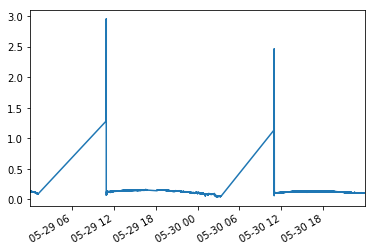

In [75]:
licor['H2OD'].plot()

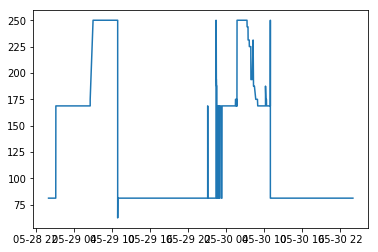

In [66]:
plt.plot(licor.index,agc)

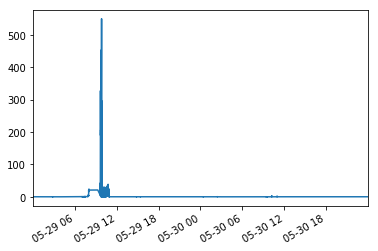

In [13]:
licor['H2OD'].plot()

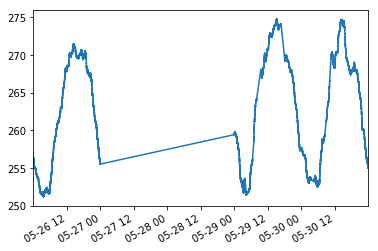

In [28]:
licor['T'].plot()

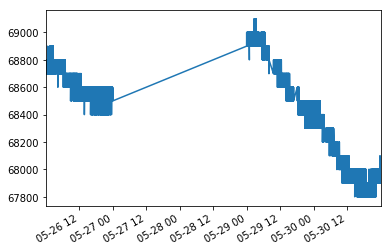

In [29]:
licor['P'].plot()